In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import copy as cp

from matplotlib import animation, rc
from IPython.display import HTML
#PRINTING THE DISLOCATION POSITIONS
def print_dis():
    print(x_dis, y_dis)
    

#CAUTION, SOME FORMULAE GIVEN IN THE THESIS NEED TO BE RECHECKED - STRESS FIELD AND THE VELOCITY PROFILE
#GRID GENERATION

#Grid size in terms of Burger's vector, Burger's vector = 1unit in the x-direction
#The grid is a sqaure
grid_size = 30

#Finding out the grid coordinates
x_coord = np.linspace(0, grid_size - 1, grid_size)
y_coord = x_coord
#print(y_coord)

#GENERATING THE DISLOCATIONS

#Number of disclocations = num_dis
num_dis = 5

#Dislocations identity = (x, y ,s); where s can be +1 or -1 DEFINED GLOBALLY. THE COORDINATES OF THE DISLOCATIONS ARE UPDATED 
#GLOBALLY
s = [1, -1]
x_dis = np.random.choice(x_coord, num_dis)
y_dis = np.random.choice(y_coord, num_dis)
s_dis = np.random.choice(s, num_dis)
print_dis()

#PLOTTING FUNCTION
def plot_dis():
    #Plotting the dislocations
    plt.axis([0, grid_size - 1, 0, grid_size - 1])
    plt.xlabel('x(b)')
    plt.ylabel('y(b)')
    plt.title('Dislocations In The Box')
    plt.grid(True)

    for i in range(len(s_dis)):
        if s_dis[i] == 1:
            plt.plot(x_dis[i], y_dis[i], 'r^')
        
        else:
            plt.plot(x_dis[i], y_dis[i], 'bv')
    plt.show()

"""
ON HOLD
#ANNIHILATION FUNCTION
#The dislocations will be annihilated if the distance between them is strictly less than the length of the burger's vector

def annhilate(b):
    for i in range(len(x_dis))
a = [1, 2, 3, 4]
del(a[1]
"""    


[11.  8.  3.  6. 27.] [ 6.  0. 26.  7. 14.]


"\nON HOLD\n#ANNIHILATION FUNCTION\n#The dislocations will be annihilated if the distance between them is strictly less than the length of the burger's vector\n\ndef annhilate(b):\n    for i in range(len(x_dis))\na = [1, 2, 3, 4]\ndel(a[1]\n"

In [2]:
#STRESS FIELD AT A PARTICULAR POINT


#The function evaluates the stress field at a point in the box. It takes the position of the dislocation(xd, yd) whose stress at a 
#point(x, y) has to be calculated. Burger's vector is kept as 1. Stress is measured in terms of meu/(2*pi*(1-v)). 
#Time is measured in terms of 2*pi*(1-neu)/(meu * mobi * burgers)
def stress_field(x_d, y_d, x, y):
    stress = 1 * np.sin(2 * np.pi * (x - x_d)/grid_size) * (np.cosh(2 * np.pi * (y - y_d)/grid_size) - np.cos(2 * np.pi * (x - x_d)/grid_size) - 
                                                           (2 * np.pi * (y - y_d)/grid_size) * np.sinh(2 * np.pi * (y - y_d)/grid_size))/((np.cosh(2 * np.pi * (y - y_d)/grid_size) - np.cos(2 * np.pi * (x - x_d)/grid_size)) ** 2 * grid_size)
    
    return stress
    
#CALCULATING THE 

In [3]:
#CALCULATING THE VELOCITY OF EACH DISLOCATION

#No climbing, just gliding =====> y is constant

#The following function calculates the (sum stress + sigma_ext) * s * b^2 at dislocation(x, y), z = s_dis(x,y)
def sum_stress(x, y, z, x_dummy, stress_external):
    sum_inter = 0 
    for i in range(len(x_dummy)):
        if x == x_dummy[i] and y == y_dis[i]:
            continue
        else:
            sum_inter = sum_inter + stress_field(x_dummy[i], y_dis[i], x, y) * s_dis[i]
    sum_inter = sum_inter + stress_external
    #Burgers vector value is 1
    return(z * sum_inter)

#NEW LOCATION OF THE DISLOCATION

#Units of timestep are 2 * pi * (1 - neu)/(meu * mobi * Burger). Timestep thus I am taking is 1000

def new_location(step, stress_ext):
    x_int = cp.deepcopy(x_dis)
    x_dummy = cp.deepcopy(x_dis)
    
    a = [0.0] * len(x_dummy)
    for i in range(len(x_dummy)):
        a[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
            
            
    for i in range(len(x_dummy)):
        x_dummy[i] = x_dis[i] + step/2.0 * np.array(a[i])
        #print(x_dis[i],x_dis[i] + step/2.0 * a[i],x_dummy[i],'{:.16f}'.format(x_dummy[i] - x_dis[i]))
    
    b = cp.deepcopy(a)
    for i in range(len(x_dummy)):
        b[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
        
    for i in range(len(x_dummy)):
        x_dummy[i] = x_dis[i] + step/2 * b[i]
    
    c = cp.deepcopy(b)
    
    for i in range(len(x_dummy)):
        c[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
        
    for i in range(len(x_dummy)):
        x_dummy[i] = x_dis[i] + step * c[i]
        
    d = cp.deepcopy(c)
    
    for i in range(len(x_dummy)):
        d[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
    
    for i in range(len(x_dummy)):
        x_dis[i] = (x_dis[i] + step/6 * (a[i] + 2 * b[i] + 2 * c[i] + d[i]))%grid_size
       
    return x_int
     

#LOCATION AFTER "t" TIMESTEPS
def location_after_t(t, step, stress):
    strain = [0] * t 
    for j in range(t):
        dummy = new_location(step, stress)
        for k in range(len(s_dis)):
            strain[j] = (strain[j] + s_dis[k] * (x_dis[k] - dummy[k]))
        
        strain[j] = strain[j]/(grid_size ** 2)
    for i in range(t):
        if i != 0:
            strain[i] = strain[i] + strain[i - 1] 
            
    return strain



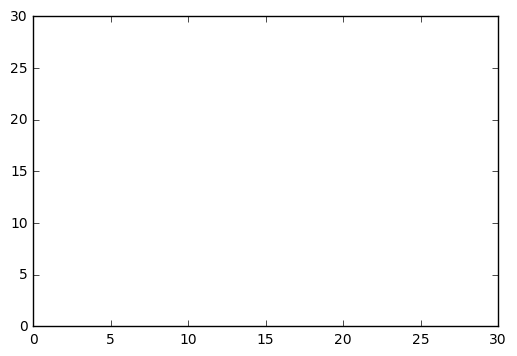

In [4]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, grid_size))
ax.set_ylim((0, grid_size))

line, = ax.plot([], [], 'ro')


###### print_dis()
plot_dis()

In [5]:
def init():
    line.set_data([], [])
    return (line,)

In [6]:
def animate(i):
    y = np.copy(y_dis)
    location_after_t(1, 1, 0)
    x = np.copy(x_dis)
    line.set_data(x, y)
    return (line,)

In [7]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=200, blit=True)


In [8]:
HTML(anim.to_html5_video())

In [9]:
print(-1%10)

9
